In [6]:
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.manifold import TSNE
from scipy.stats import norm
from sklearn.cluster import KMeans
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import pickle

with open(r'C:\Users\imran\DataspellProjects\WalidCase\data\raw\startup_dataset.csv', 'r', encoding='utf-8', errors='ignore') as f:
    raw_startups = pd.read_csv(f)

raw_industries = pd.read_csv(r'C:\Users\imran\DataspellProjects\WalidCase\data\processed\industry_dataset_clean.csv', sep='\t')

# Thoughts

## Reasoning
There are several different methods to go forward from here. Since this is a work assignment and not actually work, I feel compelled to elaborate on my thought process a bit more than I usually do things. It'll take more time this way but will also show how I work, which is the base point of this assignment in the first place. Since this is a multi-text classification problem, in my mind, there is one of three methods that can work:

#### - TFIDF + NB
This is the usual method for text classification that I have used. It is a very simple method, and it is very fast. It is also very easy to implement. The downside is that it is not very accurate. It is also not very flexible, and it is not very good at handling outliers. In my experience it has been good at handling large datasets with 10+ labels. The issue is I have never tried to use this method given a dataset without labels. When I did the exploring science bit, I started off by generalizing the words to specific topics and had a large dataset, cleaned and  labelled. I then used the topics as labels. For this project to work with this pipeline I need to either start tagging right away or start off by making the tagging easier by reducing the number of labels. Perhaps I could categorize all the industries into super-categories such as tech, science, news etc. I could also try to do some clustering in order to give me a better idea of which clusters exist and thereby maybe give me some clues as to how distributed the data is.

#### LLM
- Prompting
The most obvious and probably best answer to all of this is to produce a prompt for an LLM model. The prompt can be something like these are some industries: x, y, z and you are a classification bot that takes input as the description of a startup and outputs the industry that it belongs to. This is a very good approach because it is very flexible and can handle outliers very well. It is also very accurate. The downside is that it is very slow and very expensive. I have never done this before but maybe the prompt can say something like `write a piece of code for each description that appends your predictions to the dataframe`. This method can have different questions like 'how many founders are there, which stage are these startups at' etc. I can then just run the model. I dont know how feasible it is to do this with large amounts of startups though given the time it takes, but I can try it out.
- Embeddings
LLMs can be used to make embeddings which can help to predict the industry of a startup. I can use the embeddings to cluster the startups and then use the clusters as labels. I can also use the embeddings to calculate cosine similarity between different industries and the descriptions


In [9]:
print(f'Number of industries: {len(raw_industries)}\n'
      f'Number of startups: {len(raw_startups)}')

raw_startups.shape


Number of industries: 122
Number of startups: 4000


(4000, 3)

I reasoned that perhaps looking for matches in the industry df vs the startup df could provide some insights. The results were completely inaccurate

In [10]:
def assign_industry_to_startup(raw_startups, raw_industries):
    assigned_industries = []

    for _, startup in raw_startups.iterrows():
        best_match_count = 0
        best_match_industry = None

        for _, industry in raw_industries.iterrows():
            keywords = industry['industry'].lower().split()
            match_count = sum([1 for keyword in keywords if keyword in startup['cb_description'].lower()])

            if match_count > best_match_count:
                best_match_count = match_count
                best_match_industry = industry['industry']

        assigned_industries.append(best_match_industry)

    raw_startups['industry'] = assigned_industries
    return raw_startups

assigned_startups = assign_industry_to_startup(raw_startups, raw_industries)


In [28]:
assigned_startups

,id,name,cb_description,industry
0,1820,0xKYC,"Modular, zero knowledge system for identity cr...",Edge Computing
1,1536,100ms,100ms is a live-video infrastructure platform ...,Network Infrastructure
2,3640,10X-Genomics,10x Genomics is creating revolutionary DNA seq...,Space Tech
3,9594,111Skin,111Skin is committed to positive luxury skinca...,Future of Work
4,4697,1715Labs,1715Labs is a company being established to com...,Space Tech
...,...,...,...,...
3995,6882,Rosaly,Rosaly gives you the ability to manage advance...,Space Tech
3996,4394,Roslin-Technologies,Roslin Tech is on a mission to improve protein...,Space Tech
3997,1036,Rossum,Rossum solves four key steps in document-based...,Business Intelligence
3998,8697,Rotaready,"Developed for hospitality, leisure and retail;...",Retail


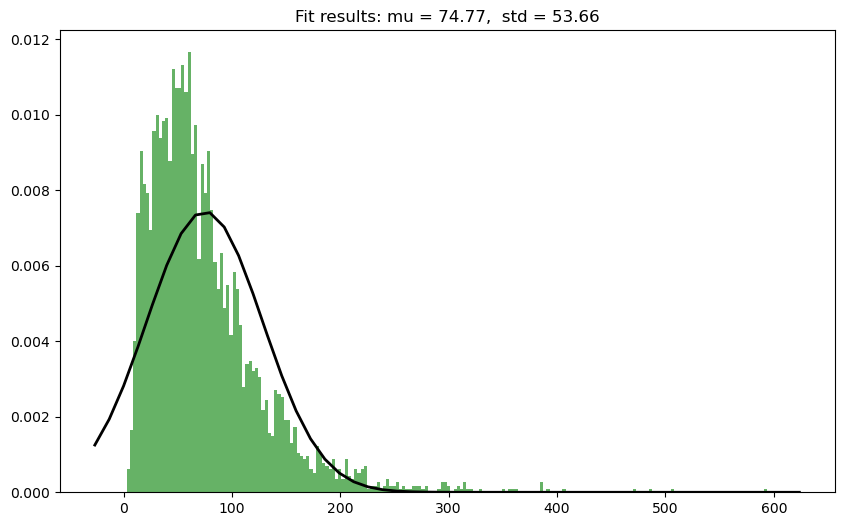

In [11]:

raw_startups.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

about_us_lengths = [len(s.split()) for s in raw_startups['cb_description']]# if 15 < len(s.split()) < 60]
mean, std = norm.fit(about_us_lengths)

ax.hist(about_us_lengths, bins=200, density=True, alpha=0.6, color='g')
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax)
p = norm.pdf(x, mean, std)
ax.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = {:.2f},  std = {:.2f}".format(mean, std)
ax.set_title(title)
plt.show()

In [73]:
ls = [item for item in about_us_lengths if item > 30]
len(ls)

3226

# Base Class

The base class vectorizes the data with TFIDF

In the first iteration, I tried to do a quick and dirty approach. I did zero preprocessing of the data, and directly applied clustering to the raw data as received by Walid. I figured this could serve as a baseline to whether different approaches were becoming better or worse with fine-tuning. I kept all model parameters standard.

I also decided to go with the NLP approach, simply because it is the one I have most experience with. After doing this with NLP, I aim to repeat the process with an LLM and compare the results.

These are some things I want to play around with:

- Different algorithms

- Different algorithm parameters

- Different degrees of preprocessing

In [47]:
class TestingAlgos:

    def __init__(self, data, n_topics=10, n_clusters=10, cluster_dimensions=2):
        self.data = data
        self.n_clusters = n_clusters
        self.cluster_dimensions = cluster_dimensions
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=False
        )

        # # # # Topic Modelling Algos # # # #

        self.LDA = LatentDirichletAllocation(
            n_components=n_topics,
            learning_method='online',
            learning_offset=50,
            random_state=0
        )
        self.NMF = NMF(
            n_components=n_topics,
            init='nndsvd',
            random_state=0,
            max_iter=500
        )
        self.LSA = TruncatedSVD(
            n_components=n_topics,
            algorithm='arpack',
            random_state=0
        )

        self.TSNE = TSNE(
            n_components=self.cluster_dimensions,
            perplexity=50,
            learning_rate=200,
            random_state=0
        )

        # # # # Clustering Algos # # # #

        self.KM = KMeans(
            n_clusters=self.n_clusters,
            random_state=0
        )

        self.DBSCAN = DBSCAN(
            eps=0.5,
            min_samples=5
        )

        self.HC = AgglomerativeClustering(
            n_clusters=self.n_clusters,
            linkage='ward'
        )


    def Tfidf(self):
        self.about_us = self.data['cb_description'].tolist()
        return self.tfidf.fit_transform(self.about_us)

    def visualize_clusters(self, algorithm='LDA', clustering='KM'):
        sparse_matrix = self.Tfidf()
        dense_matrix = sparse_matrix.toarray()
        if algorithm == 'LDA':
            model = self.LDA
        elif algorithm == 'NMF':
            model = self.NMF
        elif algorithm == 'LSA':
            model = self.LSA
        else:
            raise ValueError('Invalid algorithm')

        topic_matrix = model.fit_transform(dense_matrix)
        #cluster_labels = model.transform(dense_matrix).argmax(axis=1)

    # Visualize clusters
        self.tsne_output = self.TSNE.fit_transform(dense_matrix)
        #self.tsne_output = self.TSNE.fit_transform(topic_matrix)

        if clustering == 'KM':
            cluster_labels = self.KM.fit_transform(self.tsne_output)
            cluster_labels = cluster_labels.argmax(axis=1)
        elif clustering == 'HC':
            cluster_labels = self.HC.fit_predict(self.tsne_output)
        elif clustering == 'DBSCAN':
            cluster_labels = self.DBSCAN.fit_predict(self.tsne_output)
            noise_points = cluster_labels == -1
            self.tsne_output = self.tsne_output[~noise_points]
            cluster_labels = cluster_labels[~noise_points]
        else:
            raise ValueError('Invalid clustering algorithm')


        plt.figure(figsize=(8,6))
        plt.scatter(self.tsne_output[:, 0], self.tsne_output[:, 1], c= cluster_labels)
        plt.title(f'{algorithm} clustering with TFIDF and {clustering} (2D)')
        plt.show()


# Testing TFIDF with 3 different common algorithms for topic modeling and using TSNE for clustering

## n_topics = 10
In my first iteration, I decided to make the number of topics = 10. It is a very small number compared to the possible list of industries, but is a nice round number and I will gradually increase the number of topics. The results below show a very large degree of overlap between most of the topics, and clustering more or less failed for all algos apart from maybe NMF, which produced the most clear cluster-like shape. There is still a very large degree of overlap, so the number of topics will need to increase.

This can also be because of other factors such as the TSNE parameters but will first go with increasing the number of topics.

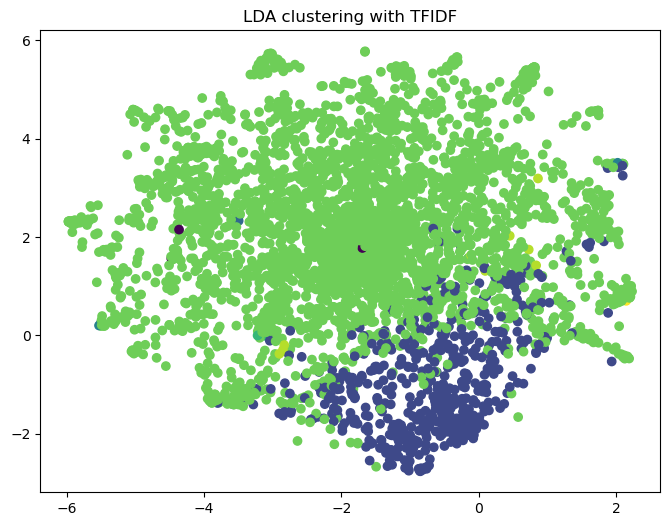

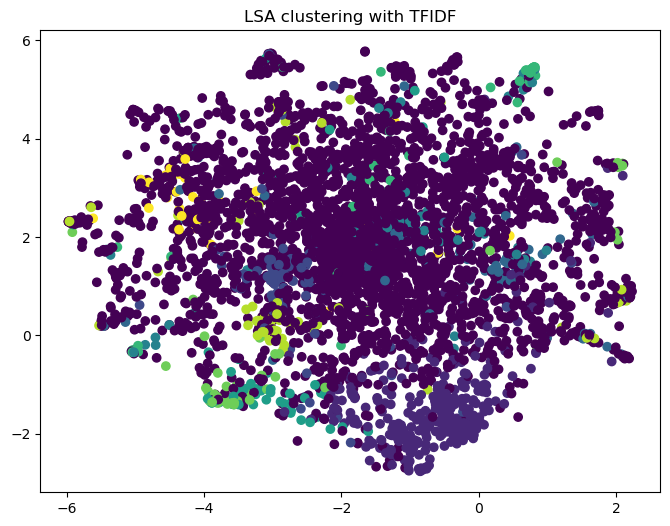

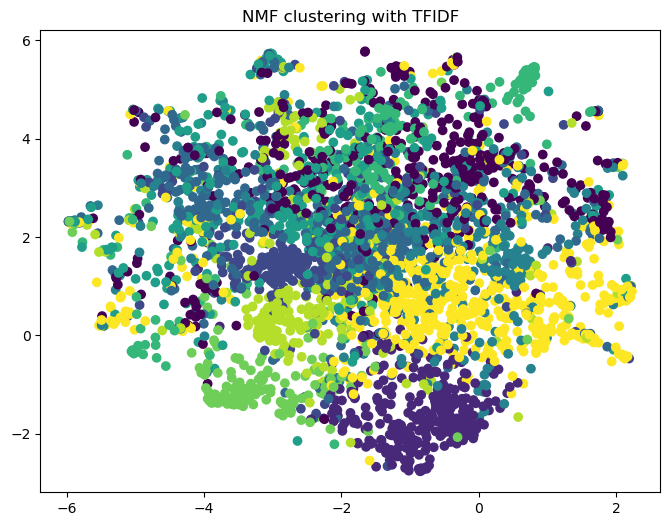

In [58]:
test_algos = TestingAlgos(data=raw_startups, n_topics=10)

test_algos.visualize_clusters(algorithm='LDA')
test_algos.visualize_clusters(algorithm='LSA')
test_algos.visualize_clusters(algorithm='NMF')

## n = 70

In this iteration I increased the number of topics to 70.

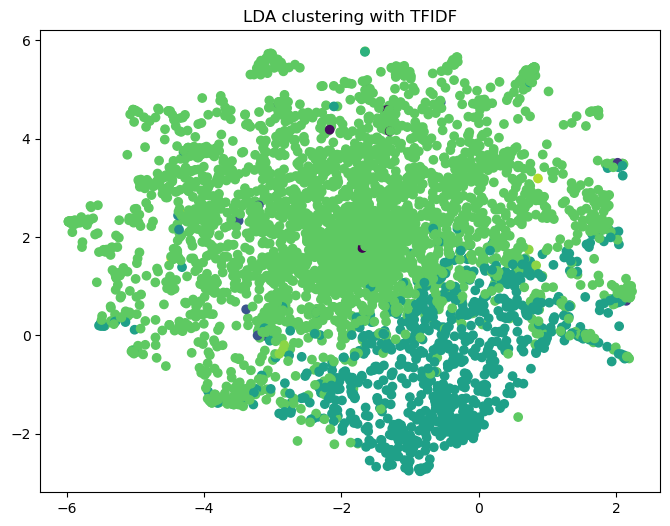

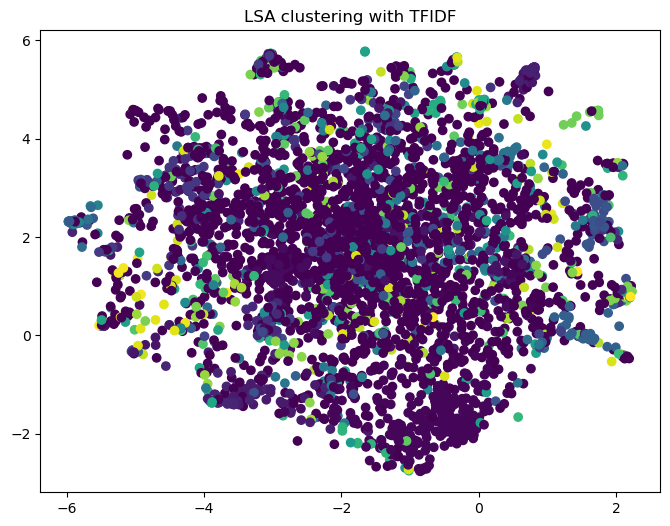

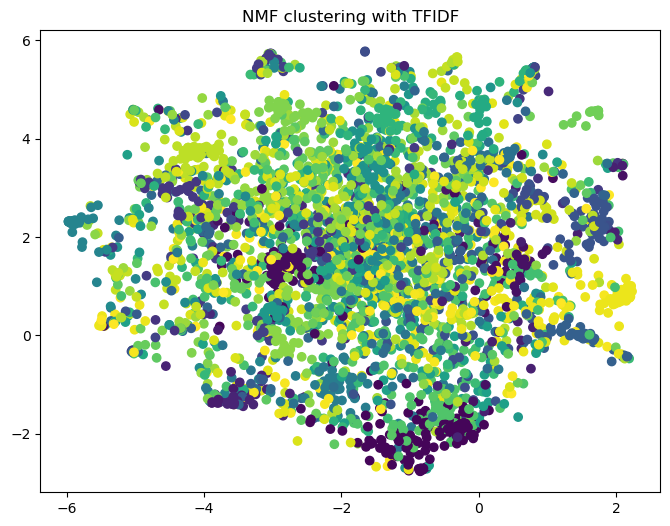

TypeError: TestingAlgos.__init__() got an unexpected keyword argument 'cluster_dimensions'

In [8]:
test_algos = TestingAlgos(data=raw_startups, n_topics=70)

test_algos.visualize_clusters(algorithm='LDA')
test_algos.visualize_clusters(algorithm='LSA')
test_algos.visualize_clusters(algorithm='NMF')

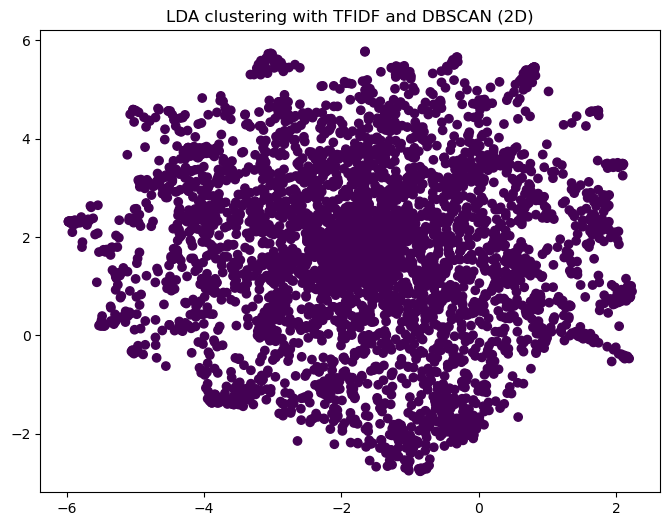

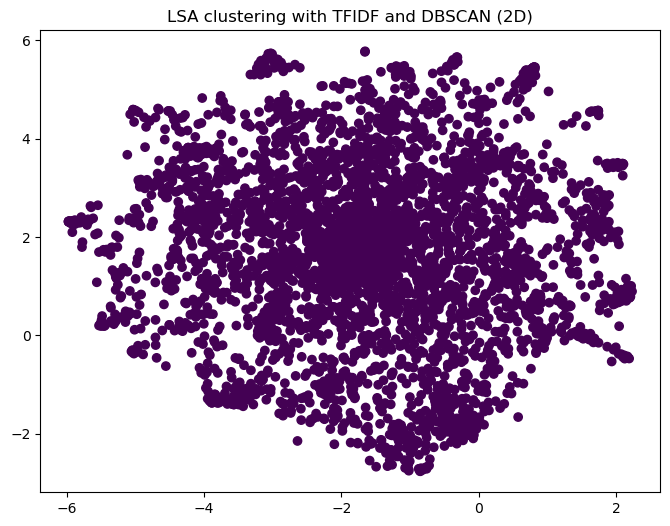

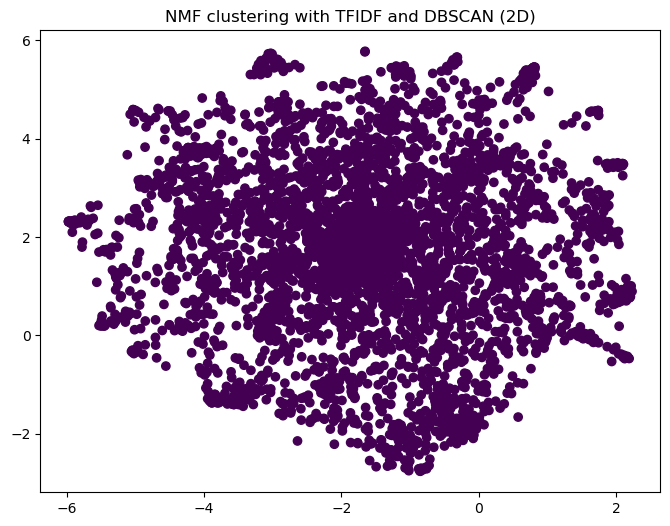

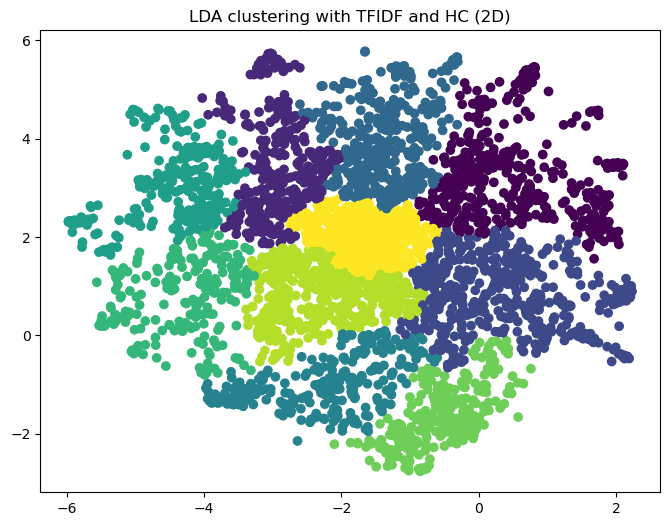

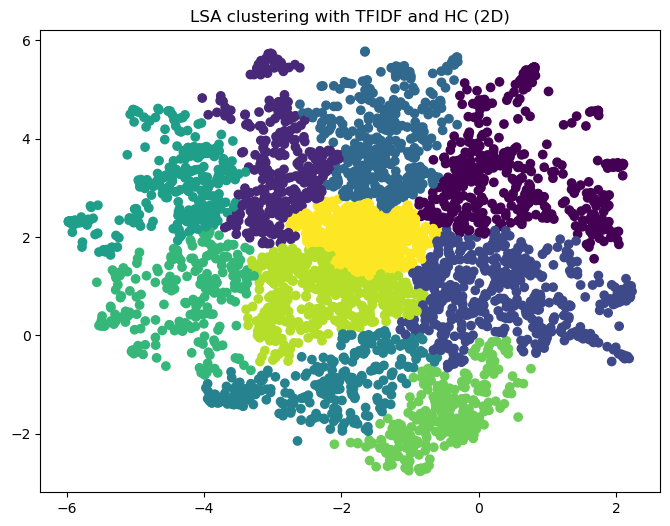

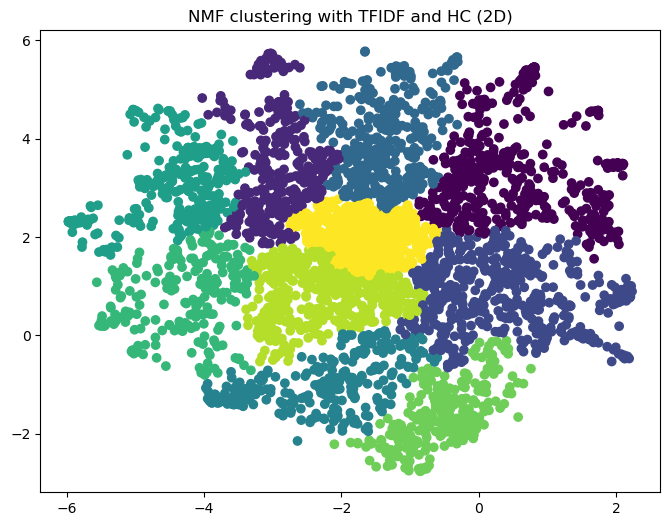

In [48]:
test_algos = TestingAlgos(data=raw_startups, n_topics=70, cluster_dimensions=2)

test_algos.visualize_clusters(algorithm='LDA', clustering='DBSCAN')
test_algos.visualize_clusters(algorithm='LSA', clustering='DBSCAN')
test_algos.visualize_clusters(algorithm='NMF', clustering='DBSCAN')

test_algos.visualize_clusters(algorithm='LDA', clustering='HC')
test_algos.visualize_clusters(algorithm='LSA', clustering='HC')
test_algos.visualize_clusters(algorithm='NMF', clustering='HC')
